adapted from Gempy by Miguel

In [457]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


### defne the input points

In [458]:
## defining the dips position
G_1 = np.array([[1.5, 1.3]])

G_1_x = -0.4
G_1_y = 1

G_1_tiled = np.tile(G_1,[2,1])

In [459]:
def squared_euclidean_distance(x_1,x_2):
    sqd = np.sqrt(np.reshape(np.sum(x_1**2,1),newshape =(x_1.shape[0],1))+\
    np.reshape(np.sum(x_2**2,1),newshape =(1,x_2.shape[0]))-\
    2*(x_1@x_2.T))
    return sqd

In [460]:
def cartesian_dist(x_1,x_2):
    return np.concatenate([
        np.tile(x_1[:,0] - np.reshape(x_2[:,0],[x_2.shape[0],1]),[1,2]),
        np.tile(x_1[:,1] - np.reshape(x_2[:,1],[x_2.shape[0],1]),[1,2])],axis = 0) 
h_u = cartesian_dist(G_1,G_1)
h_v = h_u.T

In [461]:
a = np.concatenate([np.ones([G_1.shape[0],G_1.shape[0]]),np.zeros([G_1.shape[0],G_1.shape[0]])],axis = 1)
b = np.concatenate([np.zeros([G_1.shape[0],G_1.shape[0]]),np.ones([G_1.shape[0],G_1.shape[0]])],axis = 1)

perpendicularity_matrix = np.concatenate([a,b],axis = 0)

In [462]:
dist_tiled = squared_euclidean_distance(G_1_tiled,G_1_tiled)

In [463]:
a_T = 5
c_o_T = a_T**2/14/3

In [464]:
def cov_gradients(dist_tiled):
    
    condition1 = 0
    a = (h_u*h_v)
    b = dist_tiled**2
    condition2 = (np.divide(a, b, out=np.zeros_like(a), where=b!=0)*\
    (-c_o_T*((-14/a_T**2)+105/4*dist_tiled/a_T**3 - 35/2 * dist_tiled**3 / a_T **5 + 21 /4 * dist_tiled**5/a_T**7)+
        c_o_T * 7 * (9 * dist_tiled ** 5 - 20 * a_T ** 2 * dist_tiled ** 3 +
                                       15 * a_T ** 4 * dist_tiled - 4 * a_T ** 5) / (2 * a_T ** 7)-
        perpendicularity_matrix * c_o_T * ((-14 / a_T ** 2) + 105 / 4 * dist_tiled / a_T ** 3 -
                                   35 / 2 * dist_tiled ** 3 / a_T ** 5 +
                                   21 / 4 * dist_tiled ** 5 / a_T ** 7))+
        1/3*np.eye(dist_tiled.shape[0]))

    C_G = np.where(dist_tiled==0, condition1, condition2) ## adding nugget effect
    return C_G


In [465]:
dist_tiled = dist_tiled + np.eye(dist_tiled.shape[0])

C_G = cov_gradients(dist_tiled)

C_G

array([[0.33333333, 0.        ],
       [0.        , 0.33333333]])

### covariance of interface points

In [466]:
# layer1 = np.array([[0,0],[2,0]])
# layer2 = np.array([[0,2],[2,2]])

layer1 = np.array([[0,0],[2,0.5],[3,0],[4,0]])
layer2 = np.array([[0,2],[2,2.5],[3,2],[4,2]])

number_of_layer = 2

In [467]:
number_of_points_per_surface = np.array([layer1.shape[0],layer2.shape[0]])

In [468]:
def set_rest_ref_matrix(number_of_points_per_surface):
    ref_layer_points = np.repeat(np.stack([layer1[-1],layer2[-1]],axis = 0),repeats=number_of_points_per_surface-1,axis = 0)
    rest_layer_points = np.concatenate([layer1[0:-1],layer2[0:-1]],axis = 0)
    return ref_layer_points,rest_layer_points

In [469]:
ref_layer_points,rest_layer_points = set_rest_ref_matrix(number_of_points_per_surface)

In [470]:
sed_rest_rest = squared_euclidean_distance(rest_layer_points,rest_layer_points)
sed_ref_rest = squared_euclidean_distance(ref_layer_points,rest_layer_points)
sed_rest_ref = squared_euclidean_distance(rest_layer_points,ref_layer_points)
sed_ref_ref = squared_euclidean_distance(ref_layer_points,ref_layer_points)

In [471]:
def cov_interface(ref_layer_points,rest_layer_points):
    sed_rest_rest = squared_euclidean_distance(rest_layer_points,rest_layer_points)
    sed_ref_rest = squared_euclidean_distance(ref_layer_points,rest_layer_points)
    sed_rest_ref = squared_euclidean_distance(rest_layer_points,ref_layer_points)
    sed_ref_ref = squared_euclidean_distance(ref_layer_points,ref_layer_points)
    
    C_I = c_o_T*((1 - 7 * (sed_rest_rest / a_T) ** 2 +\
                 35 / 4 * (sed_rest_rest / a_T) ** 3 -\
                 7 / 2 * (sed_rest_rest / a_T) ** 5 +\
                 3 / 4 * (sed_rest_rest / a_T) ** 7) -\
                 (1 - 7 * (sed_ref_rest / a_T) ** 2 +\
                  35 / 4 * (sed_ref_rest / a_T) ** 3 -\
                  7 / 2 * (sed_ref_rest / a_T) ** 5 +\
                  3 / 4 * (sed_ref_rest / a_T) ** 7) -\
                 (1 - 7 * (sed_rest_ref / a_T) ** 2 +\
                  35 / 4 * (sed_rest_ref / a_T) ** 3 -\
                  7 / 2 * (sed_rest_ref / a_T) ** 5 +\
                  3 / 4 * (sed_rest_ref / a_T) ** 7) +\
                 (1 - 7 * (sed_ref_ref / a_T) ** 2 +\
                  35 / 4 * (sed_ref_ref / a_T) ** 3 -\
                  7 / 2 * (sed_ref_ref / a_T) ** 5 +\
                  3 / 4 * (sed_ref_ref / a_T) ** 7))
    
    return C_I

In [472]:
C_I = cov_interface(ref_layer_points,rest_layer_points)

In [473]:
C_I

array([[1.17808762, 0.58904381, 0.1902019 , 0.48149444, 0.24074722,
        0.06928362],
       [0.58904381, 0.7343738 , 0.34159331, 0.24074722, 0.2899119 ,
        0.19158094],
       [0.1902019 , 0.34159331, 0.2513219 , 0.06928362, 0.11132384,
        0.09844242],
       [0.48149444, 0.24074722, 0.06928362, 1.17808762, 0.58904381,
        0.1902019 ],
       [0.24074722, 0.2899119 , 0.11132384, 0.58904381, 0.7343738 ,
        0.34159331],
       [0.06928362, 0.19158094, 0.09844242, 0.1902019 , 0.34159331,
        0.2513219 ]])

### Covariance of interface points and gradients

In [474]:
sed_dips_rest = squared_euclidean_distance(G_1_tiled,rest_layer_points)
sed_dips_ref = squared_euclidean_distance(G_1_tiled,ref_layer_points)

In [475]:
## Cartesian distance between dips and interface points

def cartesian_dist_no_tile(x_1,x_2):
    return np.concatenate([
        np.transpose((x_1[:,0] - np.reshape(x_2[:,0],[x_2.shape[0],1]))),
        np.transpose((x_1[:,1] - np.reshape(x_2[:,1],[x_2.shape[0],1])))],axis = 0) 

hu_rest = cartesian_dist_no_tile(G_1,rest_layer_points)
hu_ref = cartesian_dist_no_tile(G_1,ref_layer_points)

In [476]:
def cov_interface_gradients(hu_rest,hu_ref):
    C_GI = (hu_rest*(- c_o_T * ((-14 / a_T ** 2) + 105 / 4 * sed_dips_rest / a_T ** 3 -
                                  35 / 2 * sed_dips_rest ** 3 / a_T ** 5 +
                                  21 / 4 * sed_dips_rest ** 5 / a_T ** 7))-\
    hu_ref*(-c_o_T * ((-14 / a_T ** 2) + 105 / 4 * sed_dips_ref / a_T ** 3 -
                                  35 / 2 * sed_dips_ref ** 3 / a_T ** 5 +
                                  21 / 4 * sed_dips_ref ** 5 / a_T ** 7)))
    return C_GI

In [477]:
C_GI = cov_interface_gradients(hu_rest,hu_ref)
C_IG = C_GI.T

### Kriging Matrix

In [478]:
K = np.concatenate([np.concatenate([C_G,C_GI],axis = 1),
np.concatenate([C_IG,C_I],axis = 1)],axis = 0)


In [479]:
import pandas as pd
pd.DataFrame(K)

,0,1,2,3,4,5,6,7
0,0.333333,0.000000,0.286528,0.012362,-0.043627,0.367624,0.067056,-0.055505
1,0.000000,0.333333,0.079913,0.111388,0.079913,-0.055033,-0.169913,-0.055033
2,0.286528,0.079913,1.178088,0.589044,0.190202,0.481494,0.240747,0.069284
3,0.012362,0.111388,0.589044,0.734374,0.341593,0.240747,0.289912,0.191581
4,-0.043627,0.079913,0.190202,0.341593,0.251322,0.069284,0.111324,0.098442
5,0.367624,-0.055033,0.481494,0.240747,0.069284,1.178088,0.589044,0.190202
6,0.067056,-0.169913,0.240747,0.289912,0.111324,0.589044,0.734374,0.341593
7,-0.055505,-0.055033,0.069284,0.191581,0.098442,0.190202,0.341593,0.251322


In [480]:
b = np.concatenate([[G_1_x,G_1_y],np.zeros(K.shape[0]-G_1.shape[0]*2)],axis = 0)
b = np.reshape(b,newshape = [b.shape[0],1])
b

array([[-0.4],
       [ 1. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ]])

In [481]:
w = np.linalg.solve(K,b)
w

array([[-3.16580582],
       [ 4.4775143 ],
       [ 0.71868346],
       [-1.06454016],
       [-1.40955084],
       [ 0.3159829 ],
       [ 2.46937585],
       [-2.14869894]])

### Interpolation without Universal term

In [482]:
## create grid

xx = np.arange(-.5,4.5,0.1)
yy = np.arange(-.5,3.5,0.1)
XX,YY = np.meshgrid(xx,yy)
X = (np.reshape(XX,[-1])).T
Y = (np.reshape(YY,[-1])).T

grid = np.stack([X,Y],axis = 1)

In [483]:
hu_Simpoints = cartesian_dist_no_tile(G_1,grid)

In [484]:
sed_dips_SimPoint = squared_euclidean_distance(G_1_tiled,grid)

In [485]:
# gradient contribution
sigma_0_grad = w[:G_1.shape[0]*2] * (-hu_Simpoints*(- c_o_T * ((-14 / a_T ** 2) + 105 / 4 * sed_dips_SimPoint / a_T ** 3 -
                               35 / 2 * sed_dips_SimPoint ** 3 / a_T ** 5 +
                               21 / 4 * sed_dips_SimPoint ** 5 / a_T ** 7)))

sigma_0_grad = np.sum(sigma_0_grad,axis=0)

In [486]:
sed_rest_SimPoint = squared_euclidean_distance(rest_layer_points,grid)
sed_ref_SimPoint = squared_euclidean_distance(ref_layer_points,grid)

In [487]:
# surface point contribution
sigma_0_interf = -w[G_1.shape[0]*2:]*(c_o_T  * ((1 - 7 * (sed_rest_SimPoint / a_T) ** 2 +
             35 / 4 * (sed_rest_SimPoint / a_T) ** 3 -
             7 / 2 * (sed_rest_SimPoint / a_T) ** 5 +
             3 / 4 * (sed_rest_SimPoint / a_T) ** 7) -
             (1 - 7 * (sed_ref_SimPoint / a_T) ** 2 +
              35 / 4 * (sed_ref_SimPoint / a_T) ** 3 -
              7 / 2 * (sed_ref_SimPoint / a_T) ** 5 +
              3 / 4 * (sed_ref_SimPoint / a_T) ** 7)))
sigma_0_interf = np.sum(sigma_0_interf,axis = 0)

In [488]:
interpolate_result = sigma_0_grad+sigma_0_interf
intp = np.reshape(interpolate_result,YY.shape)

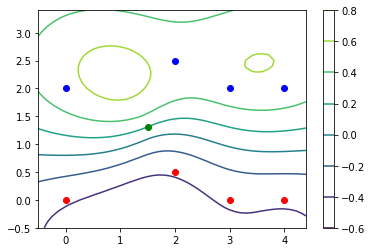

In [489]:
plt.contour(XX,YY,intp)
plt.colorbar()
plt.plot(layer1[:,0], layer1[:,1], 'ro')
plt.plot(layer2[:,0], layer2[:,1], 'bo')

plt.plot(G_1[0,0], G_1[0,1], 'go')

## add drift term

In [490]:
U = np.concatenate([np.eye(number_of_layer),
np.stack([ref_layer_points[:,0] - rest_layer_points[:,0],
ref_layer_points[:,1] - rest_layer_points[:,1]])],axis = 1)

U_T = U.T


In [491]:
### new K matrix

zero_matrix = np.zeros([2,2])

K_U = np.concatenate([np.concatenate([K,U_T],axis = 1),np.concatenate([U,zero_matrix],axis = 1)],axis = 0)

In [492]:
pd.DataFrame(K_U)

,0,1,2,3,4,5,6,7,8,9
0,0.333333,0.000000,0.286528,0.012362,-0.043627,0.367624,0.067056,-0.055505,1.0,0.0
1,0.000000,0.333333,0.079913,0.111388,0.079913,-0.055033,-0.169913,-0.055033,0.0,1.0
2,0.286528,0.079913,1.178088,0.589044,0.190202,0.481494,0.240747,0.069284,4.0,0.0
3,0.012362,0.111388,0.589044,0.734374,0.341593,0.240747,0.289912,0.191581,2.0,-0.5
4,-0.043627,0.079913,0.190202,0.341593,0.251322,0.069284,0.111324,0.098442,1.0,0.0
5,0.367624,-0.055033,0.481494,0.240747,0.069284,1.178088,0.589044,0.190202,4.0,0.0
6,0.067056,-0.169913,0.240747,0.289912,0.111324,0.589044,0.734374,0.341593,2.0,-0.5
7,-0.055505,-0.055033,0.069284,0.191581,0.098442,0.190202,0.341593,0.251322,1.0,0.0
8,1.000000,0.000000,4.000000,2.000000,1.000000,4.000000,2.000000,1.000000,0.0,0.0
9,0.000000,1.000000,0.000000,-0.500000,0.000000,0.000000,-0.500000,0.000000,0.0,0.0


In [493]:
### universal contribution
sigma_0_1st_drift = np.sum(grid * (w[-2:]).T,axis = 1)
sigma_0_1st_drift

array([-0.16033846,  0.08659913,  0.33353671, ...,  3.06580217,
        3.31273976,  3.55967734])

In [494]:
# rhs b-vector
b = np.concatenate([[G_1_x,G_1_y],np.zeros(K_U.shape[0]-G_1.shape[0]*2)],axis = 0)
b = np.reshape(b,newshape = [b.shape[0],1])

In [495]:
w = np.linalg.solve(K_U,b)
w

array([[-3.16670359],
       [ 2.07461195],
       [ 0.07701152],
       [ 1.25494913],
       [-2.50928757],
       [ 0.33051314],
       [ 2.89427478],
       [-4.2525553 ],
       [-0.04310235],
       [ 0.63897978]])

In [496]:
# gradient contribution
sigma_0_grad = w[:G_1.shape[0]*2] * (-hu_Simpoints*(- c_o_T * ((-14 / a_T ** 2) + 105 / 4 * sed_dips_SimPoint / a_T ** 3 -
                               35 / 2 * sed_dips_SimPoint ** 3 / a_T ** 5 +
                               21 / 4 * sed_dips_SimPoint ** 5 / a_T ** 7)))

sigma_0_grad = np.sum(sigma_0_grad,axis=0)

# surface point contribution
sigma_0_interf = -w[G_1.shape[0]*2:-2]*(c_o_T  * ((1 - 7 * (sed_rest_SimPoint / a_T) ** 2 +
             35 / 4 * (sed_rest_SimPoint / a_T) ** 3 -
             7 / 2 * (sed_rest_SimPoint / a_T) ** 5 +
             3 / 4 * (sed_rest_SimPoint / a_T) ** 7) -
             (1 - 7 * (sed_ref_SimPoint / a_T) ** 2 +
              35 / 4 * (sed_ref_SimPoint / a_T) ** 3 -
              7 / 2 * (sed_ref_SimPoint / a_T) ** 5 +
              3 / 4 * (sed_ref_SimPoint / a_T) ** 7)))
sigma_0_interf = np.sum(sigma_0_interf,axis = 0)


In [497]:
sigma_0_1st_drift = np.sum(grid * (w[-2:]).T,axis = 1)
sigma_0_1st_drift

array([-0.29793871, -0.30224895, -0.30655918, ...,  1.99150138,
        1.98719114,  1.98288091])

In [498]:
interpolate_result = sigma_0_grad+sigma_0_interf+sigma_0_1st_drift

intp = np.reshape(interpolate_result,XX.shape) # reshape the result to matrix shape

-0.3534148687014758

In [523]:
G_1[0][0]

1.5

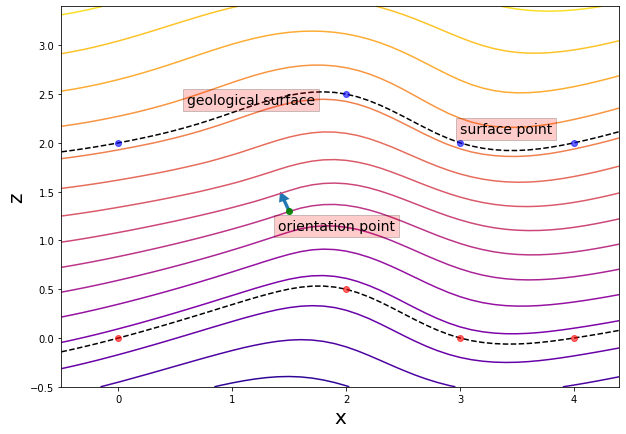

In [577]:
plt.figure(figsize=(10, 7))
plt.contour(XX, YY, intp, 18,cmap ='plasma')
plt.contour(XX, YY, intp, levels = [intp[5,35],intp[25,35]],colors='black',linestyles = 'dashed')
# plt.colorbar()
plt.plot(layer1[:,0], layer1[:,1], 'ro',alpha = .6)
plt.plot(layer2[:,0], layer2[:,1], 'bo',alpha = .6)
plt.arrow(G_1[0,0], G_1[0,1], G_1_x/5, G_1_y/5, length_includes_head=True,width=0.03,
          head_width=0.1, head_length=0.1,linewidth = 0.01)

plt.text(G_1[0,0]-0.1, G_1[0,1]-0.19, 'orientation point',fontsize=14,bbox=dict(facecolor='red', alpha=0.2))
plt.text(0.6, 2.4, 'geological surface',fontsize=14,bbox=dict(facecolor='red', alpha=0.2))
plt.text(3, 2.1, 'surface point',fontsize=14,bbox=dict(facecolor='red', alpha=0.2))

plt.xlabel('x',fontsize = 20)
plt.ylabel('z',fontsize = 20)

plt.plot(G_1[0,0], G_1[0,1], 'go',alpha = .9)
plt.savefig('/Users/zhouji/Documents/Geophysics/Liang/Fig/scalar_field.png',dpi = 500)